{PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0'): [PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/diff-bottle-model-4/log/SPH_log.txt'), PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/diff-bottle-model-3/log/SPH_log.txt'), PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/diff-bottle-model-2/log/SPH_log.txt'), PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/diff-bottle-model-1/log/SPH_log.txt'), PosixPath('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/diff-bottle-model-0/log/SPH_log.txt')]}
Files in exp2-old-omega0 : ['diff-bottle-model-0', 'diff-bottle-model-1', 'diff-bottle-model-2', 'diff-bottle-model-3', 'diff-bottle-model-4']


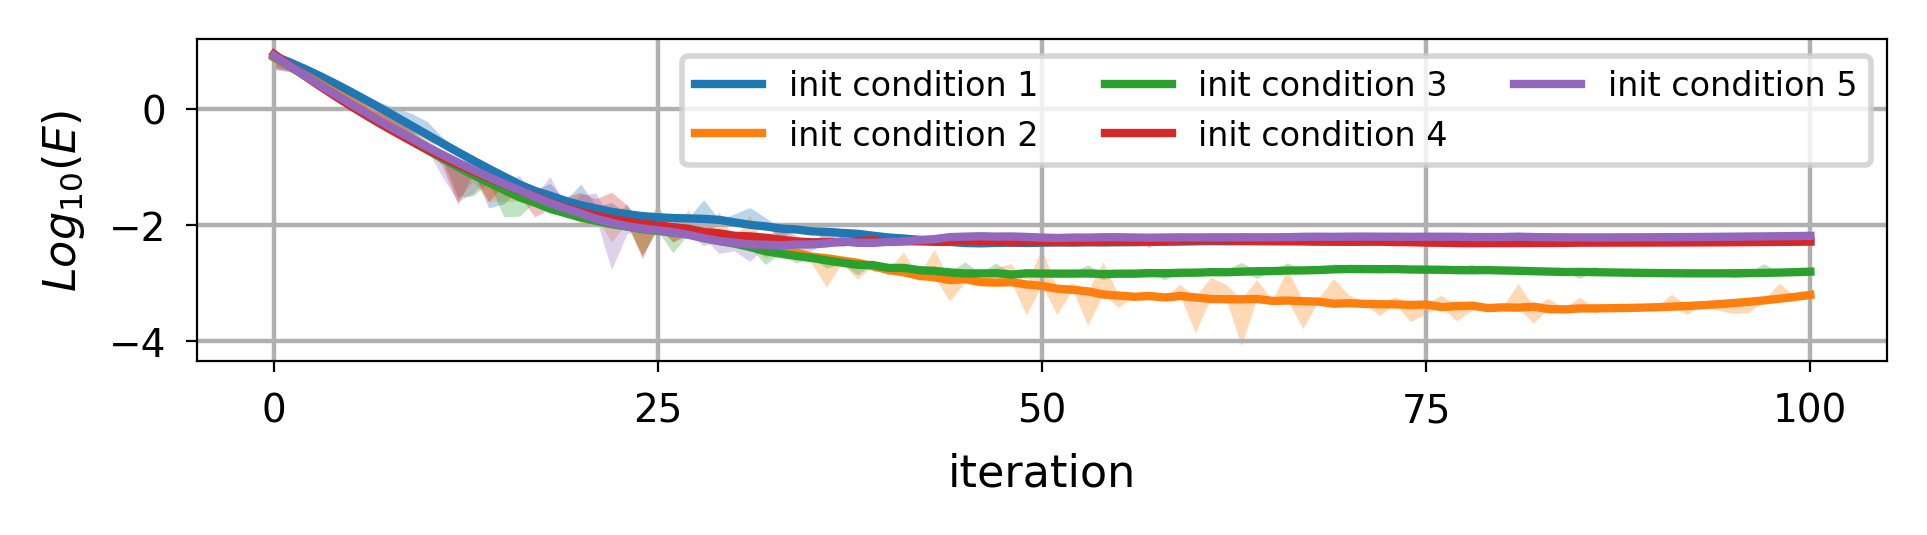

In [77]:
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np
from scipy.signal import savgol_filter

path = Path('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2-old-omega0/')
# path = Path('/home/user/zhehaoli/DiffSPH-Rigid-Coupling/pySPlisHSPlasH/revision/outputs/exp2/')

files_by_grandparent = {}

for file in path.rglob('*.txt'):
    if file.is_file():
        grandparent = file.parents[2]
        if grandparent not in files_by_grandparent:
            files_by_grandparent[grandparent] = []
        files_by_grandparent[grandparent].append(file)

print(files_by_grandparent)

def get_loss_from_log(path):
    loss_x = []
    loss_rotation = []
    loss = []   
    penalty = []   
    with open(path) as f:
        lines = f.readlines()
        for s in lines[1:]:
            s = s.split(sep='=')
            if 'loss_rotation' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss_rotation.append(l)
            if 'loss_x' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss_x.append(l)
            if 'loss ' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss.append(l)
            if 'penalty' in s[0] and 'grad' not in s[0]:
                p = float(s[1][:-5])
                penalty.append(p)
    return loss_x, loss_rotation, loss, penalty


end = 100+1

def draw(datas:list, labels, start_idx = 0, ylabel='$Log_{10}(E)$', xlabel="iteration", styles=None):
    for i in range(len(datas)):
        data = datas[i][start_idx:]
        x = list(range(len(data)))
        y = np.log10(np.array(data))
        window_size = 31
        order = 3
        y_smooth = savgol_filter(y, window_size, order)
        if styles is None:
            plt.plot(list(range(len(data))), y, label = labels[i])
            plt.plot(list(range(len(data))), y_smooth, label = labels[i])
        else:
            # plt.plot(list(range(len(data))), y, label = labels[i], color=styles[0])
            plt.plot(list(range(len(data))), y_smooth, label = labels[i])
            # Ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html#example-confidence-bands
            plt.fill_between(list(range(len(data))), np.minimum(y, y_smooth), np.maximum(y, y_smooth), alpha=0.3)
        plt.legend(fontsize = 6,loc='upper right')
        plt.xlabel(xlabel, fontsize=8)
        plt.grid(True)
        plt.xticks(np.arange(0, end, 25))
        plt.ylabel(ylabel, fontsize=8)

blue = (31 / 255, 119 / 255, 180 / 255, 1)
light_blue = (31 / 255, 119 / 255, 180 / 255, 0.5)

orange = (255 / 255, 127 / 255, 14 / 255, 1)
light_orange = (255 / 255, 127 / 255, 14 / 255, 0.5)

green = (44/255, 160/255, 44/255, 1)
light_green = (44/255, 160/255, 44/255, 0.5)

count = 1 
for grandparent in files_by_grandparent.keys():
    files = files_by_grandparent[grandparent]
    files.sort()
    plt.figure(figsize=(5,1.5), dpi=400)
    # plt.title(grandparent.name)
    print(f"Files in {grandparent.name} : {[f.parent.parent.name for f in files]}")
    for log in files:
            loss_x, loss_rotation, loss, penalty = get_loss_from_log(log)
            # print(len(loss))
            # draw([loss[::2]], [f'{log.parent.parent.name}'], styles=[light_green, green])
            draw([loss[::2]], [f'init condition {count}'], styles=[light_green, green])
            count += 1
    plt.tight_layout()
    # plt.grid(False)
    # Set font size and length for x-axis and y-axis tick labels
    plt.tick_params(axis='both', which='major', labelsize=7, length=2, width=0.4)  # Adjust length value as needed
    
    # Set font size for y-axis scale (exponent notation)
    plt.tick_params(axis='y', which='major', labelsize=7)
    ax = plt.gca()
    plt.legend(fontsize=6, ncol=3)

    #    Set the border width (linewidth) for each of the four sides
    border_width = 0.4 # You can adjust this value as needed
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
    plt.savefig('./output_plot-grid.png', transparent=True)

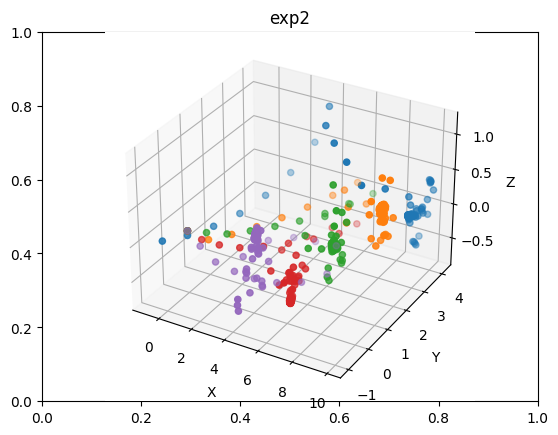

In [17]:
import numpy as np 

def get_init_v_and_omega_from_log(path):
    init_v = []
    init_omega = []
    with open(path) as f:
        lines = f.readlines()
        for s in lines[1:]:
            s = s.split(sep='=')
            if 'set init v rb' in s[0]:
                v = s[1][:-5].split()
                # print(v)
                init_v.append([float(v[0]), float(v[1]), float(v[2])])
            if 'set init omega rb' in s[0]:
                v = s[1][:-5].split()
                # print(v)
                init_omega.append([float(v[0]), float(v[1]), float(v[2])])
    return init_v, init_omega

def draw_3d_traj(ax, init_v):
    init_v = np.array(init_v)
    # Create a scatter plot
    ax.scatter(init_v[:,0], init_v[:,1], init_v[:,2], c='r', marker='o')



for grandparent in files_by_grandparent.keys():
    files = files_by_grandparent[grandparent]
    files.sort()
    # fig = plt.figure(figsize=(6,2), dpi=400)
    fig = plt.figure()
    plt.title(grandparent.name)
    ax = fig.add_subplot(111, projection='3d')
    # Set labels for the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    for idx, log in enumerate(files):
        init_v, init_omega = get_init_v_and_omega_from_log(log)
        draw_3d_traj(ax, init_v)
